In [1]:
import os
from math import pi
from time import time



# os.environ["CUDA_VISIBLE_DEVICES"] = "2, 3"  # Use only the first GPU
from autocvd import autocvd
autocvd(num_gpus = 1)

# os.environ['JAX_PLATFORM_NAME'] = 'cpu'

from typing import Optional, Tuple, Callable, Union, List
from functools import partial

import matplotlib.pyplot as plt
import jax
import jax.numpy as jnp
from jax import vmap, jit
from jax import random
jax.config.update("jax_enable_x64", True)

import numpy as np
from astropy import units as u
from astropy import constants as c


# from ott.tools.unreg import wassdis_p


import odisseo
from odisseo import construct_initial_state
from odisseo.integrators import leapfrog
from odisseo.dynamics import direct_acc, DIRECT_ACC, DIRECT_ACC_MATRIX, DIRECT_ACC_LAXMAP
from odisseo.option_classes import SimulationConfig, SimulationParams, MNParams, NFWParams, NFW_POTENTIAL, PlummerParams, MN_POTENTIAL, LogarithmicParams, LOGARITHMIC_POTENTIAL
from odisseo.initial_condition import Plummer_sphere, ic_two_body, sample_position_on_sphere, inclined_circular_velocity, sample_position_on_circle
from odisseo.utils import E_tot, Angular_momentum
from odisseo.time_integration import time_integration
from odisseo.units import CodeUnits
from odisseo.visualization import create_3d_gif, create_projection_gif, plot_last_snapshot, plot_sky_projection
from odisseo.potentials import MyamotoNagai, NFW



plt.rcParams.update({
    'font.size': 20,
    'axes.labelsize': 20,
    'xtick.labelsize': 13,
    'ytick.labelsize': 13,
    'legend.fontsize': 15,
})

In [2]:
code_length = 10.0 * u.kpc
code_mass = 1e5 * u.Msun
G = 1 
code_units = CodeUnits(code_length, code_mass, G=G)

In [3]:
# Define the 
config = SimulationConfig(N_particles=1_000, 
                          return_snapshots=True, 
                          num_snapshots=100, 
                          num_timesteps=1000, 
                          external_accelerations=(LOGARITHMIC_POTENTIAL,), 
                          acceleration_scheme= DIRECT_ACC_MATRIX,
                          softening=(0.0001 * u.pc).to(code_units.code_length).value) #default values

params = SimulationParams(t_end = (10* u.Gyr).to(code_units.code_time).value,  
                          Plummer_params= PlummerParams(Mtot=(2.5*1e5 * u.Msun).to(code_units.code_mass).value,
                                                        a=(8 * u.pc).to(code_units.code_length).value),
                         Logarithmic_Params = LogarithmicParams(v0 = (220 * u.km / u.s).to(code_units.code_velocity).value,
                                                                q = 0.9,),
                        
                          G=G, ) 

print(config)
print(params)

SimulationConfig(N_particles=1000, dimensions=3, return_snapshots=True, num_snapshots=100, fixed_timestep=True, num_timesteps=1000, softening=np.float64(1.0000000000000002e-08), integrator=0, diffrax_solver=0, acceleration_scheme=2, batch_size=10000, double_map=False, external_accelerations=(4,), differentation_mode=1, num_checkpoints=100)
SimulationParams(G=1, t_end=np.float64(0.21209672678920705), Plummer_params=PlummerParams(a=np.float64(0.0008000000000000001), Mtot=np.float64(2.5)), NFW_params=NFWParams(Mvir=162000000000.0, r_s=15.3, c=10, d_c=1.4888043637074615), PointMass_params=PointMassParams(M=1.0), MN_params=MNParams(M=65000000000.0, a=3.0, b=0.28), PSP_params=PSPParams(alpha=-1.8, r_c=1.9), Logarithmic_Params=LogarithmicParams(v0=np.float64(1060.821068368804), q=0.9))


In [ ]:
#generate Plummer sphere
positions, velocities, mass = Plummer_sphere(key=random.PRNGKey(0), params=params, config=config)
p1 = positions
#generate initial positions of the Plummer sphere
pos = jnp.array([26.0, 0.0, 0.0]) * u.kpc.to(code_units.code_length)
vel = jnp.array([0.0,-141.8, 83.1]) * (u.km/u.s).to(code_units.code_velocity)

#move the Plummer sphere to the initial position
positions = positions + pos
#add the initial velocity to the Plummer sphere
velocities = velocities + vel
#construct the initial state
initial_state = construct_initial_state(position=positions, velocity=velocities)


#simulate the evolution 
snapshots = time_integration(initial_state, mass, config, params)

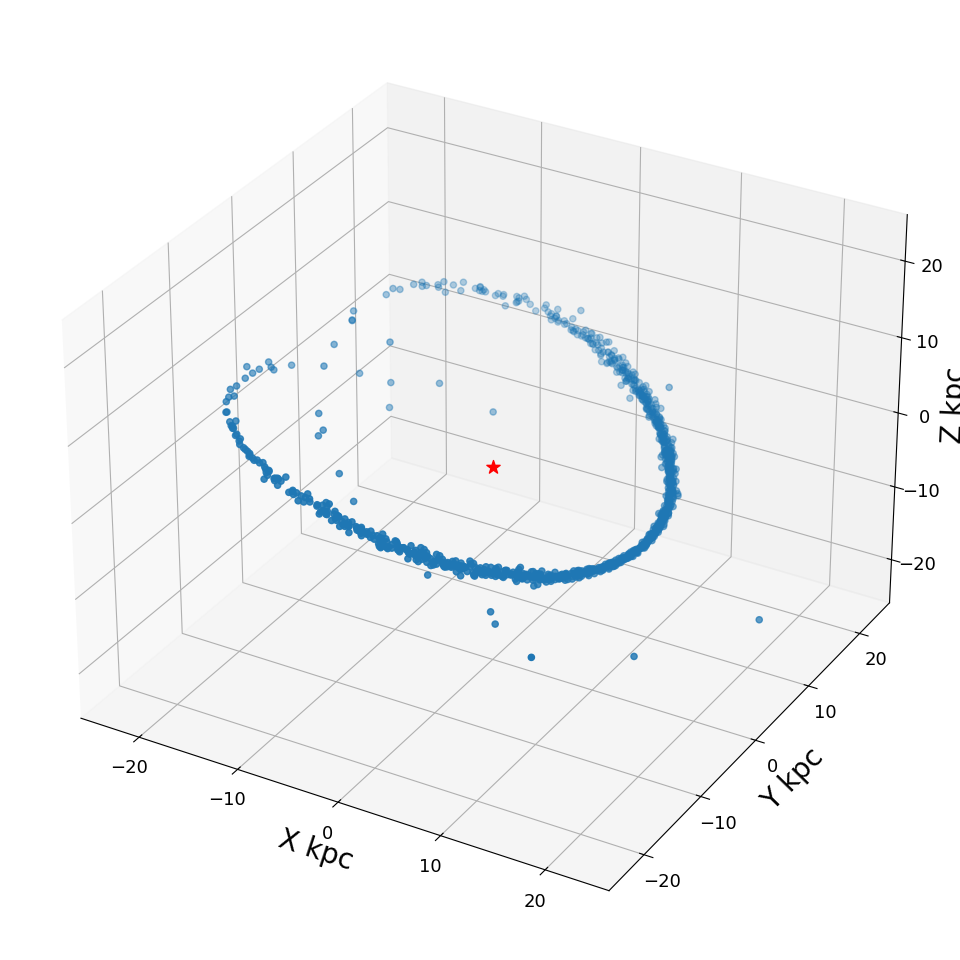

In [5]:
plot_last_snapshot(snapshots, code_units, rp=jnp.linalg.norm(pos), plotting_units_length=u.kpc, filename=None)

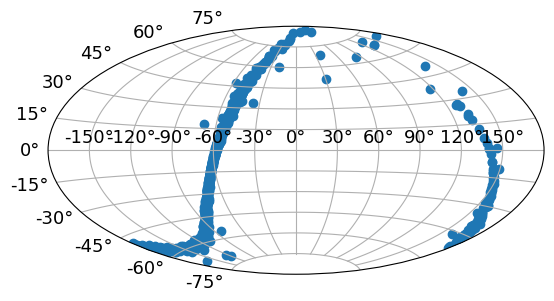

In [6]:
from astropy.coordinates import SkyCoord, CartesianRepresentation, Galactocentric
import astropy.coordinates as coord

last_snapshot = snapshots.states[-1]

x, y, z = last_snapshot[:, 0, 0], last_snapshot[:, 0, 1], last_snapshot[:, 0, 2]
x, y, z = (x * code_units.code_length).to(u.kpc) , (y * code_units.code_length).to(u.kpc), (z * code_units.code_length).to(u.kpc)
vx, vy, vz = last_snapshot[:, 1, 0], last_snapshot[:, 1, 1], last_snapshot[:, 1, 2]
vx, vy, vz = (vx * code_units.code_velocity).to(u.km/u.s), (vy * code_units.code_velocity).to(u.km/u.s), (vz * code_units.code_velocity).to(u.km/u.s)


galactic_coordinate = SkyCoord(x=x, y=y, z=z, v_x=vx, v_y=vy, v_z=vz, frame=coord.Galactocentric)

sky_coordinate = galactic_coordinate.transform_to(coord.ICRS)  # For RA/Dec

plt.subplot(111, projection='aitoff')
plt.grid(True)
plt.scatter(sky_coordinate.ra.wrap_at('180d').radian, sky_coordinate.dec.radian)

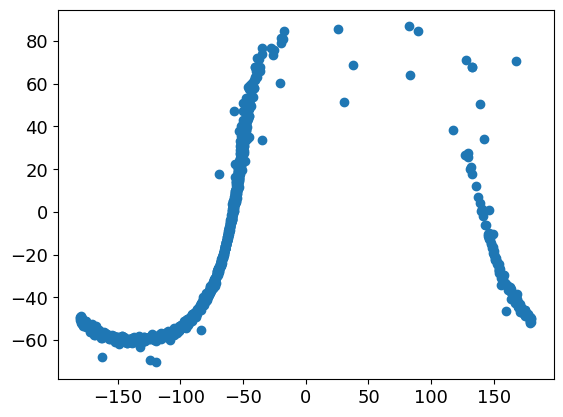

In [7]:
plt.scatter(sky_coordinate.ra.wrap_at('180d'), sky_coordinate.dec)

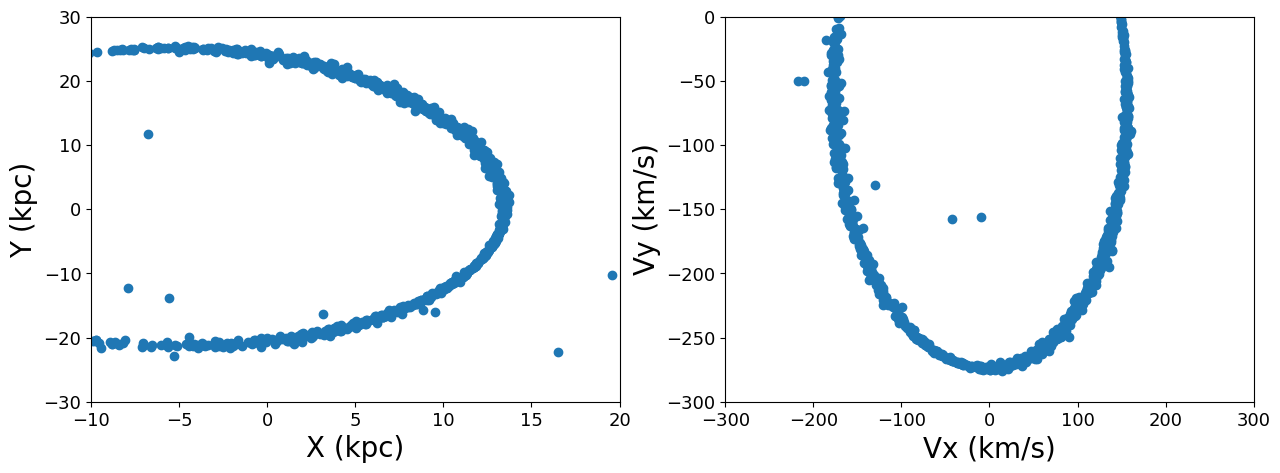

In [8]:
fig = plt.figure(figsize=(15, 5))
ax = fig.add_subplot(121)
ax.scatter(x, y)
ax.set_xlabel('X (kpc)')
ax.set_ylabel('Y (kpc)')
ax.set_xlim(-10, 20)
ax.set_ylim(-30, 30)
ax = fig.add_subplot(122)
ax.scatter(vx, vy)
ax.set_xlabel('Vx (km/s)')
ax.set_ylabel('Vy (km/s)')
ax.set_xlim(-300, 300)
ax.set_ylim(-300,0)
# ax.yaxis_inverted()
plt.show()